In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')
    
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol import AerosolMarine, AerosolBoreal

from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.physics import si

from atmos_cloud_sim_uj_utils import show_plot
import matplotlib
from matplotlib import pyplot

import numpy as np
import os
from joblib import Parallel, delayed, parallel_backend

In [2]:
CI = 'CI' in os.environ

nRes = 4
updraft_list = np.geomspace(0.1, 10, 2 if CI else nRes)

subplot_list = ["a","b","c","d"]
models = ('Constant', 'CompressedFilmOvadnevaite')

Acc = {"a": 30, "b": 134, "c": 160, "d": 540}

consts = {"delta_min":0.1, 
          "MAC":1, 
          "HAC":1, 
          "c_pd":1006 * si.joule / si.kilogram / si.kelvin, 
          "g_std":9.81 * si.metre / si.second ** 2,
          "BDF":False
          }

def compute(key, settings):
    simulation = Simulation(settings)
    output = simulation.run()
    output['updraft'] = settings.w
    output['org_fraction'] = settings.aerosol.modes[0]['f_org']
    output['color'] = settings.aerosol.color
    return key, output

print(f'tasks scheduled: {len(models) * len(subplot_list) * len(updraft_list)}')
print(updraft_list)
with parallel_backend('loky', n_jobs=-1):
    output = dict(Parallel(verbose=10)(
        delayed(compute)(subplot+f"_w{w:.2f}_"+model, Settings(
            dz = 1 * si.m if CI else 0.1 * si.m,
            n_sd_per_mode = 10 if CI else 50,
            model = model,
            aerosol = {
                "a": AerosolMarine(Forg=0, Acc_N2=Acc["a"]),
                "b": AerosolMarine(Forg=0, Acc_N2=Acc["b"]),
                "c": AerosolBoreal(Forg=0, Acc_N2=Acc["c"]),
                "d": AerosolBoreal(Forg=0, Acc_N2=Acc["d"])
            }[subplot],
            w = w * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
            **consts
        ))
        for w in updraft_list
        for subplot in subplot_list
        for model in models
    ))

tasks scheduled: 32
[ 0.1         0.46415888  2.15443469 10.        ]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:  5.3min remaining:   32.6s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  5.5min finished


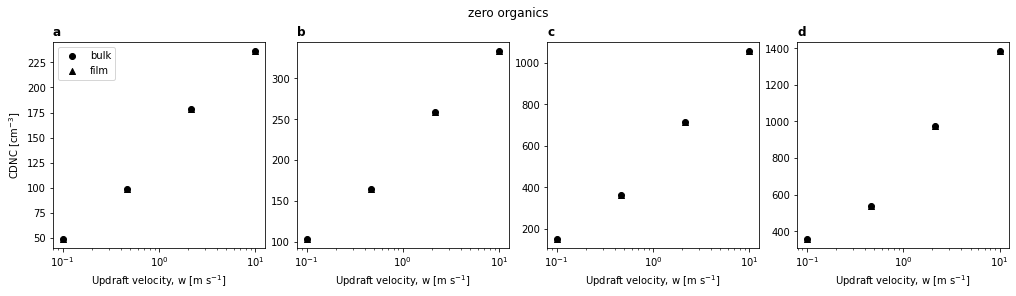

In [12]:
_, axes = pyplot.subplots(1,len(subplot_list), figsize=(14,4), constrained_layout=True, sharex=True, sharey=False)

for k, subplot in enumerate(subplot_list):
    for i, w in enumerate(updraft_list):
        key = subplot + f"_w{w:.2f}_"
        var = "n_c_cm3"
        z = np.array(output[key + "CompressedFilmOvadnevaite"]["z"])
        CDNC_film = np.array(output[key + "CompressedFilmOvadnevaite"][var])
        CDNC_bulk = np.array(output[key + "Constant"][var])

        if len(subplot_list) > 1:
            ax = axes[k]
        else:
            ax = axes
        
        a = ax.scatter(w, CDNC_bulk[-1], color="k", marker='o', label="bulk")
        b = ax.scatter(w, CDNC_film[-1], color="k", marker='^', label="film")
        ax.set_xscale('log')

        ax.set_title(subplot, loc="left", weight="bold")
        ax.set_xlabel("Updraft velocity, w [m s$^{-1}$]")
        if k == 0:
            ax.set_ylabel("CDNC [cm$^{-3}$]")
            ax.legend(["bulk","film"])            
            
pyplot.suptitle("zero organics")
pyplot.show()